# Part 7.1 - Linear Regression on Topic Modeling
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset, plot_avg
from utils_preplot import load_doctopic
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

2019-02-06 20:45:49
[('spark.driver.host', 'x99.hub'),
 ('spark.app.name', 'local'),
 ('spark.driver.maxResultSize', '8g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '41058'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6'),
 ('spark.app.id', 'local-1549439156744')]


<SparkContext master=local[*] appName=local>

**In this part we will apply a simple data mining algorithm - linear regression on topic modeling result files to find with time goes there are correlations between topics or not.**

## 1 Load Data

**Load metadata:**

In [2]:
df_meta = load_dataset('meta', spark).select(F.col('id').alias('id_'), F.col('region'), F.col('date'))
df_meta.cache()

DataFrame[id_: int, region: string, date: date]

In [3]:
df_meta.limit(5).toPandas().head()

,id_,region,date
0,1854213,Auckland,1862-06-14
1,1854215,Auckland,1862-06-14
2,1854221,Auckland,1862-06-14
3,1854224,Auckland,1862-07-03
4,1854232,Auckland,1863-08-01


**Topic List:**

In [3]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

In [5]:
print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
75,75,0.00599,show prize entries exhibition class prizes medal competition agricultural exhibits classes special society awarded p...
188,188,0.00721,damage water heavy rain earthquake flood explosion floods great river storm houses occurred night destroyed people d...
142,142,0.01130,year loan tax amount expenditure money government cent interest fund revenue pay rate paid income taxation sum cost ...
139,139,0.00250,sellers buyers stock bank sales new_zealand national exchange pref auckland waihi wellington insurance cent share or...
165,165,0.00733,oamaru aro thames dunedin otago north waitaki john street zealand fleming timaru kurow tyne hold town kakanui sumpte...


**Load doc-topic matrix:**

In [4]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id')
df_doctopic.cache();

In [7]:
print('Shape of dataframe:({}, {})'.format(df_doctopic.count(), len(df_doctopic.columns)))
df_doctopic.limit(5).toPandas().head()

Shape of dataframe:(3025602, 201)


,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1854213,0.000196,0.000321,0.777824,0.000115,0.000269,0.000154,0.000291,0.000227,0.000227,0.000143,0.000254,0.000210,0.000139,0.000235,0.000221,0.000279,0.000245,0.000247,0.000178,0.000305,0.000135,0.090193,0.000215,0.000042,0.000103,0.000260,0.000069,0.000106,0.000294,0.000197,0.000227,0.000176,0.000121,0.031044,0.000048,0.000190,0.000268,0.000177,0.000158,0.000230,0.000169,0.000165,0.000215,0.000315,0.000183,0.000184,0.000214,0.000159,0.000065,0.000088,0.000263,0.000187,0.000139,0.000104,0.000165,0.000172,0.000155,0.000288,0.000312,...,0.000170,0.000325,0.000338,0.000191,0.000035,0.000223,0.000237,0.000350,0.000084,0.000255,0.000391,0.000196,0.000191,0.000165,0.000213,0.000213,0.000292,0.000288,0.000261,0.000406,0.000239,0.000134,0.000109,0.000175,0.000244,0.000219,0.000119,0.000173,0.000272,0.000128,0.000257,0.000112,0.000072,0.000100,0.000155,0.000189,0.000134,0.000111,0.000168,0.000158,0.000222,0.000211,0.000307,0.000206,0.000256,0.000198,0.000159,0.000438,0.000215,0.000215,0.000269,0.000322,0.000177,0.000282,0.000290,0.000466,0.000188,0.000201,0.000230,0.000148
1,1854215,0.000112,0.000184,0.000379,0.000066,0.000154,0.000088,0.000166,0.000130,0.102773,0.000082,0.000146,0.000120,0.000080,0.000135,0.000126,0.000160,0.000140,0.000141,0.000102,0.000174,0.000077,0.000298,0.000123,0.000024,0.000059,0.000149,0.000040,0.000061,0.000168,0.000113,0.000130,0.000101,0.000069,0.034874,0.000028,0.000109,0.000153,0.000101,0.000091,0.000131,0.000097,0.000095,0.000123,0.000180,0.000104,0.000106,0.000123,0.000091,0.000037,0.000050,0.000151,0.000107,0.000080,0.000060,0.000094,0.000098,0.000089,0.000165,0.000178,...,0.000097,0.000186,0.000193,0.000109,0.000020,0.000128,0.000135,0.000200,0.000048,0.000146,0.000224,0.000112,0.000109,0.000094,0.000122,0.325158,0.000167,0.000165,0.000149,0.000232,0.000137,0.000077,0.000062,0.000100,0.000140,0.000125,0.000068,0.000099,0.000156,0.000073,0.000147,0.000064,0.000041,0.000057,0.000089,0.000108,0.000077,0.000064,0.000096,0.000090,0.000127,0.000121,0.000176,0.000118,0.000147,0.000113,0.000091,0.000251,0.000123,0.000123,0.000154,0.000184,0.051423,0.000161,0.000166,0.000267,0.000108,0.000115,0.000131,0.000085
2,1854221,0.000158,0.000259,0.000534,0.000093,0.000217,0.000124,0.000234,0.000184,0.000183,0.000116,0.000205,0.000169,0.000112,0.000190,0.000178,0.000225,0.000198,0.000199,0.000144,0.000246,0.000109,0.000420,0.000173,0.000034,0.000083,0.000210,0.000056,0.000086,0.000237,0.000159,0.000183,0.000142,0.000098,0.025053,0.000039,0.000154,0.000216,0.892676,0.000128,0.000185,0.000137,0.000133,0.000173,0.000254,0.000147,0.000149,0.000173,0.000128,0.000052,0.000071,0.000213,0.000151,0.000112,0.000084,0.000133,0.000139,0.000125,0.000233,0.000252,...,0.000137,0.000263,0.000273,0.000154,0.000028,0.000180,0.000191,0.000282,0.000068,0.000206,0.000316,0.000158,0.000154,0.000133,0.000172,0.000172,0.000236,0.000232,0.000210,0.024450,0.000193,0.000108,0.000088,0.000141,0.000197,0.000177,0.000096,0.000139,0.000220,0.000103,0.000208,0.000091,0.000058,0.000081,0.000125,0.000153,0.000108,0.000090,0.000136,0.000127,0.000179,0.000170,0.000248,0.000166,0.000207,0.000159,0.000129,0.000354,0.000174,0.000174,0.000217,0.000260,0.000143,0.000228,0.000234,0.000376,0.000152,0.000162,0.000185,0.000120
3,1854224,0.000148,0.000242,0.000498,0.000086,0.000203,0.000116,0.000219,0.000171,0.000171,0.000108,0.000191,0.000158,0.000105,0.000177,0.000166,0.000210,0.000185,0.000186,0.000134,0.000229,0.000102,0.000391,0.000161,0.000032,0.000077,0.000196,0.000052,0.000080,0.000221,0.000148,0.000171,0.000133,0.000091,0.000868,0.000036,0.000

## 2 Generate Dataset

**The result files of MALLET can not be used to regress directly, we need to generate a dataset for regressiong. The dataset consists of all topics, the weight of each topic is a feature, each observor/sample/row is a time unit. To sample more observor, we take month as the time unit.**

**Generate average weight-month matrix:**

In [5]:
# doc-weight-month matrix
df = (df_doctopic
      .join(df_meta, df_doctopic.id == df_meta.id_)
      .withColumn('time', F.date_format('date', 'yyyy-MM'))
      .drop('id')
      .drop('id_')
      .drop('region')
      .drop('date')
      .orderBy('time')
      )

In [6]:
# avg-weight-month matrix
df = (df
      .groupBy('time')
      .avg()
      .orderBy('time'))

df = df.toPandas()

columns = [str(x) for x in list(range(topic_number))]
columns.insert(0, 'time')
df.columns = columns

print('Shape of dataframe:', df.shape)
df.head()

Shape of dataframe: (1235, 201)


,time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1839-08,0.000026,0.000588,0.001261,0.000015,0.000035,0.000020,0.000038,0.000030,0.000030,0.000019,0.004402,0.000028,0.020061,0.032634,0.000029,0.038632,0.000032,0.027958,0.005470,0.006698,0.000018,0.000068,0.000028,0.000006,0.000014,0.000034,0.000009,0.000014,0.000039,0.000026,0.000030,0.000023,0.000016,0.002335,0.000006,0.000025,0.000035,0.000023,0.000021,0.000030,0.237546,0.000022,0.000028,0.000042,0.000024,0.010634,0.000028,0.000021,0.000009,0.000012,0.000035,0.000025,0.000564,0.001829,0.000022,0.000023,0.000020,0.000038,0.000041,...,0.000022,0.000043,0.000044,0.000025,0.000005,0.000029,0.000031,0.000046,0.000011,0.000034,0.000052,0.000026,0.000025,0.006025,0.000028,0.000028,0.000038,0.000038,0.114943,0.000053,0.000031,0.000018,0.000014,0.000023,0.000032,0.000029,0.000016,0.021308,0.004272,0.000017,0.000034,0.000015,0.000010,0.035488,0.000020,0.000025,0.000018,0.000015,0.041693,0.002204,0.000029,0.000028,0.000040,0.000027,0.000034,0.000026,0.000021,0.000058,0.000028,0.000028,0.015166,0.036836,0.000023,0.001285,0.032891,0.000061,0.000025,0.000027,0.000030,0.000020
1,1839-09,0.000011,0.000018,0.000037,0.000006,0.000015,0.000009,0.000016,0.000013,0.000013,0.000008,0.008179,0.000012,0.016606,0.000013,0.000012,0.015975,0.000014,0.000014,0.000010,0.010231,0.000008,0.027799,0.000012,0.000002,0.000006,0.000015,0.000004,0.000006,0.000016,0.000011,0.000013,0.000010,0.000007,0.000065,0.000003,0.000011,0.000015,0.000010,0.000009,0.000013,0.140755,0.000009,0.000012,0.000018,0.000010,0.000010,0.000012,0.000009,0.000004,0.000005,0.000015,0.000011,0.000008,0.000006,0.034482,0.000010,0.000009,0.000016,0.000018,...,0.000010,0.000018,0.000019,0.000011,0.000002,0.000013,0.000013,0.000020,0.000005,0.000014,0.035283,0.011821,0.000011,0.000009,0.000012,0.000012,0.000016,0.000016,0.191476,0.000023,0.000013,0.000008,0.000006,0.000010,0.000014,0.000012,0.000007,0.000010,0.000015,0.000007,0.000014,0.000006,0.000004,0.000006,0.000009,0.000330,0.000008,0.000006,0.000009,0.000009,0.000012,0.023951,0.000017,0.001372,0.000014,0.000011,0.000328,0.000025,0.000012,0.000012,0.000015,0.000337,0.000010,0.000016,0.000016,0.000026,0.026184,0.000011,0.000013,0.000008
2,1840-04,0.000037,0.003226,0.000499,0.000022,0.000050,0.000029,0.000054,0.000043,0.000043,0.000027,0.000048,0.000039,0.007663,0.000044,0.000041,0.000427,0.000046,0.000458,0.008587,0.034655,0.000025,0.034120,0.000040,0.000008,0.000019,0.000049,0.000013,0.000020,0.000055,0.000037,0.000043,0.015462,0.000023,0.000216,0.000009,0.000036,0.000050,0.000033,0.000599,0.000043,0.082383,0.000031,0.000040,0.000059,0.000034,0.000035,0.000040,0.000030,0.000387,0.000016,0.000049,0.000035,0.000026,0.060946,0.000031,0.000032,0.000029,0.000054,0.009742,...,0.000032,0.000061,0.000063,0.000036,0.000007,0.000042,0.000044,0.000066,0.001663,0.000048,0.000073,0.038876,0.000036,0.000031,0.000040,0.022423,0.000055,0.000054,0.050701,0.000076,0.000045,0.000025,0.000020,0.000033,0.013146,0.000041,0.000022,0.007155,0.000051,0.000024,0.000048,0.000021,0.000014,0.026259,0.000779,0.013754,0.000025,0.000021,0.005387,0.000030,0.000042,0.000039,0.008108,0.000039,0.000048,0.000037,0.000030,0.000082,0.000040,0.000040,0.000050,0.015036,0.000033,0.000053,0.000054,0.000087,0.039080,0.004161,0.000043,0.000028
3,1840-05,0.000082,0.000133,0.000608,0.001011,0.030028,0.003916,0.000121,0.002846,0.003005,0.000060,0.002124,0.001096,0.001319,0.001174,0.006332,0.000116,0.000102,0.002247,0.004332,0.060964,0.001281,0.013872,0.000089,0.000017,0.000043,0.004824,0.000029,0.000044,0.000122,0.000082,0.000094,0.001299,0.022893,0.006677,0.000020,0.0

## 3 Plot Dataset

**Plot month base dataframe will take too much time, we resample dataframe to year base which will plot faster.**

In [10]:
# resampling to year
df_plt = (df_doctopic
          .join(df_meta, df_doctopic.id == df_meta.id_)
          .withColumn('year', F.date_format('date', 'yyyy'))
          .drop('id')
          .drop('id_')
          .drop('region')
          .drop('date')
          .groupBy('year')
          .avg()
          .orderBy('year')
          .toPandas())

df_meta.unpersist()
df_doctopic.unpersist()

columns = [str(x) for x in list(range(topic_number))]
columns.insert(0, 'year')
df_plt.columns = columns

# melt for plot
df_plt = pd.melt(df_plt,
                 id_vars='year',
                 value_vars=list(df.columns[1:]),
                 var_name='topic',
                 value_name='weight')

# change data type
df_plt.topic = df_plt.topic.astype(int)

# join
df_plt = (df_plt
          .merge(df_topics, left_on='topic', right_on='topic_')
          .drop('topic_', axis=1)
          .drop('weight_', axis=1)
          .drop('keywords_', axis=1)
          .sort_values(by=['year', 'topic'])
          .reset_index(drop=True))

# change columns name
df_topics.columns = ['topic', 'weight', 'keywords']

print('Shape of dataframe', df_plt.shape)
df_plt.sample(5)

Shape of dataframe (20800, 3)


,year,topic,weight
8000,1879,0,0.003346
11430,1896,30,0.004827
7850,1878,50,0.002160
3413,1856,13,0.002288
17245,1928,45,0.002634


**Plot each feature to check trends:**

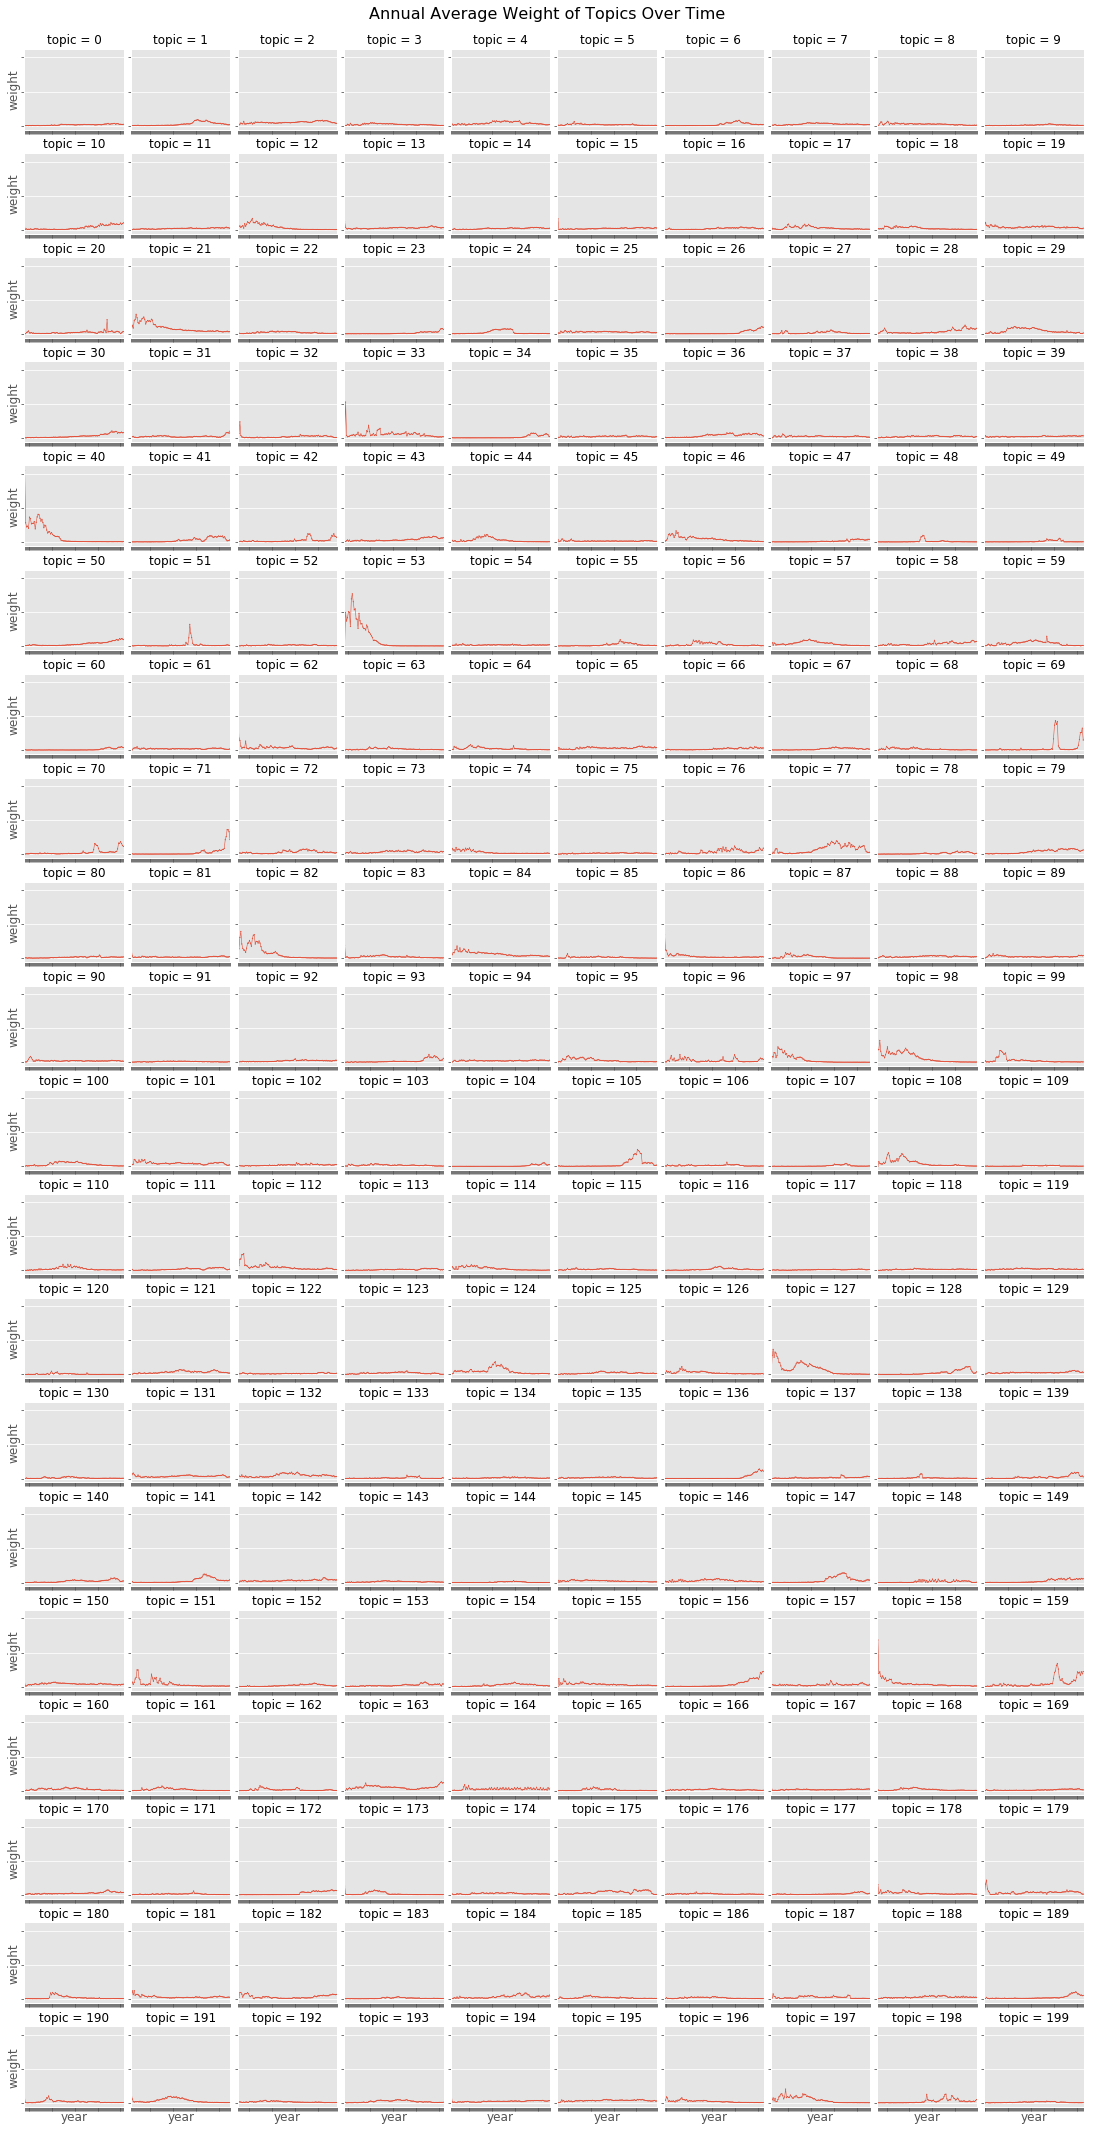

In [11]:
plot_avg(df_plt)

## 4 Search Correlation

**After we get weight-month matrix, we check the correlation among features:**

In [7]:
# remove time for regression
df.drop(columns='time', inplace=True)

# Compute pairwise correlation of Dataframe's attributes
corr = df.corr()
corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.000000,0.391316,0.473375,-0.192761,0.188727,-0.388313,0.376817,0.255415,-0.230049,0.357447,0.601390,0.557846,-0.568733,0.336612,0.604887,0.488134,0.492896,-0.228819,-0.392253,-0.145054,0.369531,-0.633956,-0.072189,0.473924,0.139151,-0.072196,0.527573,0.010697,0.454340,-0.048498,0.602421,0.121318,0.017090,-0.181332,0.558288,0.199757,0.692417,-0.034563,0.352754,0.338452,-0.631248,0.347064,0.227306,0.582176,-0.194628,-0.078840,-0.509013,0.331174,0.084270,0.115003,0.620566,0.102891,0.070222,-0.602638,0.004093,0.227946,-0.039915,-0.186066,0.435860,-0.052044,...,0.651572,0.403416,0.364013,0.239291,0.120269,-0.353413,-0.068840,0.238800,0.321553,0.501334,-0.102576,-0.442997,0.378986,0.526744,0.362039,-0.359979,0.546783,0.240211,-0.436590,0.295319,-0.160754,-0.236737,-0.185749,0.035534,0.051241,0.001364,0.068314,0.242831,-0.064670,0.508427,0.551140,0.013234,0.625705,-0.231454,0.113834,0.505018,-0.142003,0.565257,-0.403924,0.037652,-0.113840,-0.211454,0.040980,0.295953,0.299556,-0.139937,-0.143016,-0.065599,0.287051,0.560880,-0.233624,-0.078548,-0.285170,0.146570,0.545968,0.279212,-0.449866,-0.495593,0.262795,0.124967
1,0.391316,1.000000,0.448566,-0.253754,0.284594,-0.187739,0.866682,0.130389,-0.219538,0.726341,0.534197,0.388077,-0.554265,0.281084,0.464181,0.446114,0.712004,-0.367945,-0.472229,0.004129,0.256416,-0.548687,-0.148591,0.230173,-0.094542,-0.178500,0.141729,0.237724,0.376935,-0.241207,0.381477,-0.030736,0.079428,-0.075449,0.299793,0.254862,0.601016,-0.103823,0.246746,0.273294,-0.503760,0.360895,0.365858,0.451116,-0.427491,-0.084701,-0.474243,0.296944,0.000003,0.745117,0.436668,0.086159,0.254642,-0.476235,-0.071511,0.743048,-0.219432,-0.398408,0.511026,0.065981,...,0.348082,0.816216,0.319280,0.058483,0.483460,-0.322359,0.012660,0.790856,0.246163,0.630183,-0.082940,-0.411924,0.701650,0.514973,0.684329,-0.365034,0.236286,0.210438,-0.343145,0.397255,-0.213496,-0.383990,-0.289216,-0.364076,0.110320,-0.279980,-0.051407,0.068134,-0.356369,0.419453,0.411291,0.247363,0.557374,-0.386651,0.047870,0.364299,-0.321303,0.308013,-0.400475,0.046255,-0.260527,-0.214972,-0.159799,0.253872,0.696355,-0.191514,-0.271520,0.094890,0.308640,0.203690,-0.218447,-0.321631,-0.367276,0.170604,0.338261,0.366748,-0.431624,-0.565701,0.635465,0.437976
2,0.473375,0.448566,1.000000,-0.043977,0.156034,-0.223267,0.422022,0.063739,-0.198730,0.325604,0.458849,0.372588,-0.371295,0.220119,0.437635,0.340452,0.459693,-0.173409,-0.298053,-0.036258,0.288923,-0.390714,-0.117677,0.249169,-0.045956,-0.006010,0.270700,-0.020297,0.356187,-0.089181,0.390538,-0.072398,-0.013354,-0.153705,0.442202,0.252149,0.483991,0.039434,0.287736,0.247600,-0.388725,0.366725,0.066469,0.470936,-0.260265,-0.085672,-0.318066,0.233807,-0.031417,0.207766,0.369032,0.051250,0.153751,-0.416750,-0.054824,0.288271,-0.113328,-0.253716,0.296013,-0.073016,...,0.444640,0.445602,0.262789,-0.002762,0.092704,-0.215993,-0.101701,0.285904,0.267045,0.421779,0.019315,-0.246673,0.402835,0.498031,0.367888,-0.205726,0.285397,0.190305,-0.335746,0.118470,-0.124493,-0.203156,0.001202,-0.116921,0.101632,-0.164637,0.102197,0.169411,-0.128615,0.401776,0.511813,-0.007545,0.435609,-0.198938,0.086409,0.490821,-0.152940,0.491979,-0.249437,0.043794,-0.154517,-0.097648,-0.039658,0.056792,0.255379,-0.142705,-0.149114,-0.068031,0.241588,0.328558,-0.067567,-0.282520,-0.214278,0.027931,0.351504,0.356684,-0.328879,-0.396618,0.260458,0.115215
3,-0.192761,-0.253754,-0.043977,1.000000,0.165159,0.195386,-0.308120,0.299459,0.118745,-0.087184,-0.412183,-0.202440,0.206084,-0.120218,-0.077588,-0.181162,-0.270964,0.403983,0.287228,

**Plot heatmap:**

Text(0.5, 0.98, 'Topic Weight Correlation Heatmap')

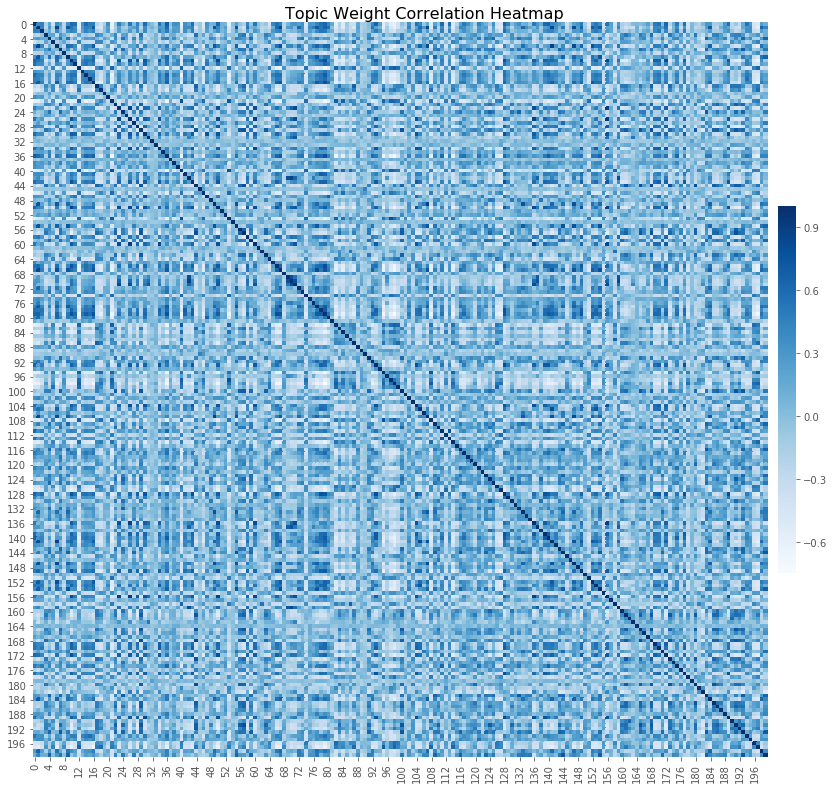

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize=(14,11))

g = sns.heatmap(corr, 
                ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                cmap=plt.cm.Blues, # Color Map.
                cbar=True,
                cbar_kws={"shrink": .5, 'pad':0.01},
                square=True,     # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                annot=False 
                #fmt='.2f',       # String formatting code to use when adding annotations.
                #annot_kws={"size": 14},
                #linewidths=.05
               )

fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.subplots_adjust(top=0.96)
fig.suptitle('Topic Weight Correlation Heatmap', 
              fontsize=16) 

**List the highest positive 10 correlation pairs:**

In [8]:
df_corr = df.corr().unstack().sort_values(kind='quicksort', ascending=False)
df_corr_p = pd.DataFrame(df_corr[200:210]).reset_index()
df_corr_p.columns = ['pair1', 'pair2', 'corr']
df_corr_p.T

,0,1,2,3,4,5,6,7,8,9
pair1,156,26,26,60,23,156,136,156,26,136
pair2,26,156,60,26,156,23,156,136,136,26
corr,0.920104,0.920104,0.915811,0.915811,0.898647,0.898647,0.892402,0.892402,0.890969,0.890969


In [9]:
topic_list = list(set(df_corr_p.pair1.unique()).union(set(df_corr_p.pair2.unique())))

print('The highest {} correlated topics: {}'.format(len(topic_list), topic_list))

The highest 5 correlated topics: ['136', '26', '156', '60', '23']


Text(0.5, 0.98, 'Topic Weight Correlation Heatmap')

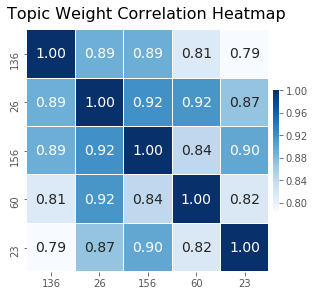

In [24]:
# Compute pairwise correlation of Dataframe's attributes
corr = df[topic_list].corr()

fig, (ax) = plt.subplots(1, 1, figsize=(5,4))

g = sns.heatmap(corr, 
                ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                cmap=plt.cm.Blues, # Color Map.
                cbar=True,
                cbar_kws={"shrink": .5, 'pad':0.01},
                square=True,     # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                annot=True,
                fmt='.2f',       # String formatting code to use when adding annotations.
                annot_kws={"size": 14},
                linewidths=.01
               )

fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.subplots_adjust(top=0.9)
fig.suptitle('Topic Weight Correlation Heatmap', 
              fontsize=16) 

**Before calculate correlation and plot the highest correlated topics, we scale them for better visualization:**

In [16]:
df_plt = df[topic_list]

scaler = MinMaxScaler()

df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt), columns=df_plt.columns)

**Plot pairwise plots:**

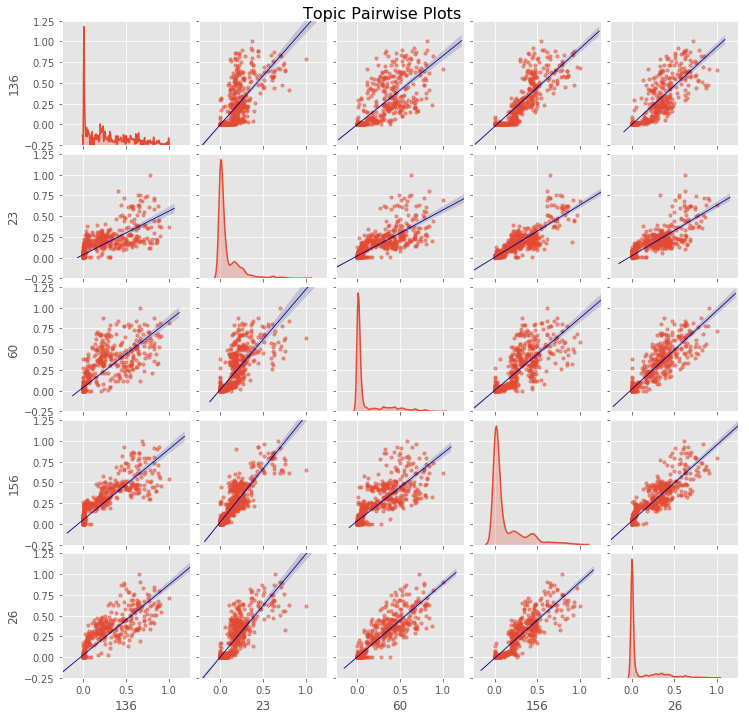

In [17]:
g = sns.pairplot(df_plt_scaled, 
                 diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                 diag_kind="kde",           # use "kde" for diagonal plots
                 #diag_kind="auto",
                 plot_kws={'line_kws':{'color':'navy', 'linewidth':0.8},
                           'scatter_kws': {'alpha': 0.5, 's':10}},
                 height=2.0,
                 aspect=1,
                 kind="reg")                # linear regression to the scatter plots

g.set(xlim=(-0.25,1.25), ylim = (-0.25,1.25))
fig = g.fig 
fig.suptitle('Topic Pairwise Plots', fontsize=16)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.subplots_adjust(top=0.96, wspace=0.07, hspace=0.07)
plt.savefig('../temp/plot_regression.png')  
plt.show()  
plt.close()

**List the highest negative 10 correlation pairs:**

In [18]:
df_corr = df.corr().unstack().sort_values(kind='quicksort', ascending=True)
df_corr_n = pd.DataFrame(df_corr[:10]).reset_index()
df_corr_n.columns = ['pair1', 'pair2', 'corr']
df_corr_n.T

,0,1,2,3,4,5,6,7,8,9
pair1,79,98,36,98,79,95,36,40,21,79
pair2,98,79,98,36,95,79,40,36,79,21
corr,-0.746022,-0.746022,-0.709083,-0.709083,-0.695489,-0.695489,-0.694752,-0.694752,-0.691323,-0.691323


In [19]:
topic_list = list(set(df_corr_n.pair1.unique()).union(set(df_corr_n.pair2.unique())))

print('The highest {} correlated topics: {}'.format(len(topic_list), topic_list))

The highest 6 correlated topics: ['21', '98', '36', '95', '40', '79']


**Before calculate correlation and plot the highest correlated topics, we scale them for better visualization:**

In [20]:
df_plt = df[topic_list]

scaler = MinMaxScaler()

df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt), columns=df_plt.columns)

**Plot pairwise plots:**

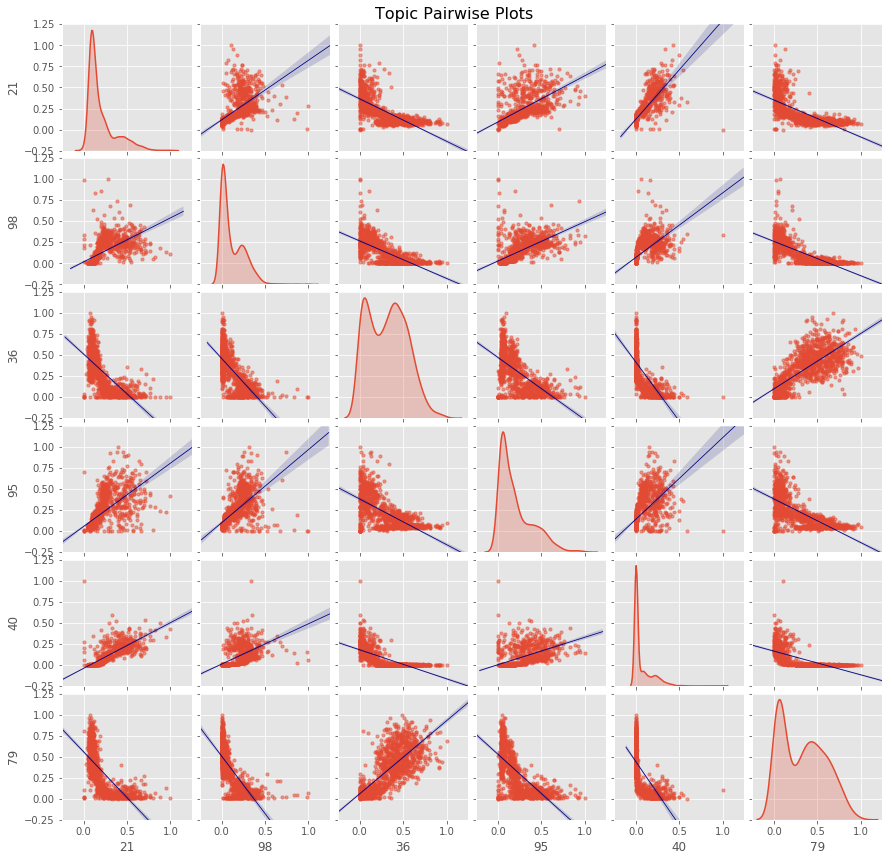

In [21]:
g = sns.pairplot(df_plt_scaled, 
                 diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                 diag_kind="kde",           # use "kde" for diagonal plots
                 #diag_kind="auto",
                 plot_kws={'line_kws':{'color':'navy', 'linewidth':0.8},
                           'scatter_kws': {'alpha': 0.5, 's':10}},
                 height=2.0,
                 aspect=1,
                 kind="reg")                # linear regression to the scatter plots

g.set(xlim=(-0.25,1.25), ylim = (-0.25,1.25))
fig = g.fig 
fig.suptitle('Topic Pairwise Plots', fontsize=16)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.subplots_adjust(top=0.96, wspace=0.06, hspace=0.06)
plt.show()  

## 5 Linear Regression

**From above plot we see the negative correlations are ambiguous, while some positive correlations are strong. We select one pair of them to perform linear regression.**

In [22]:
pair = list(df_corr_p.iloc[0][0:2])
print('Topics pair to perform linear regression:', pair)

Topics pair to perform linear regression: ['156', '26']


In [23]:
df_topics[df_topics['topic'].isin(pair)].head()

,topic,weight,keywords
26,26,0.00231,post wanted sell buy anted street good cash furniture write prices sale ring price apply wellington radio condition ...
156,156,0.00977,government scheme department board work made system service local present public control minister new_zealand time d...


In [24]:
# scale score to 0 - 1
scaler = MinMaxScaler()

# gen dataset
x = scaler.fit_transform(df.loc[:, pair[0]].values.reshape(-1,1))
y = scaler.fit_transform(df.loc[:, pair[1]].values.reshape(-1,1))

# Split the dataset into the training set and test set
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25, random_state = 1)

# model
lr = LinearRegression()

# training
lr.fit(xTrain, yTrain)

# predicting
yPred = lr.predict(xTest)

# the coefficient of determination (R^2)
print('R^2:', lr.score(xTrain, yTrain))

# The coefficients
print('Coefficients:', lr.coef_[0][0])

# The mean squared error
print("Mean squared error: {:.2f}".format(mean_squared_error(yTest, yPred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: {:.2f}'.format(r2_score(yTest, yPred)))

R^2: 0.8506329109731594
Coefficients: 0.9134614769322321
Mean squared error: 0.00
Variance score: 0.83


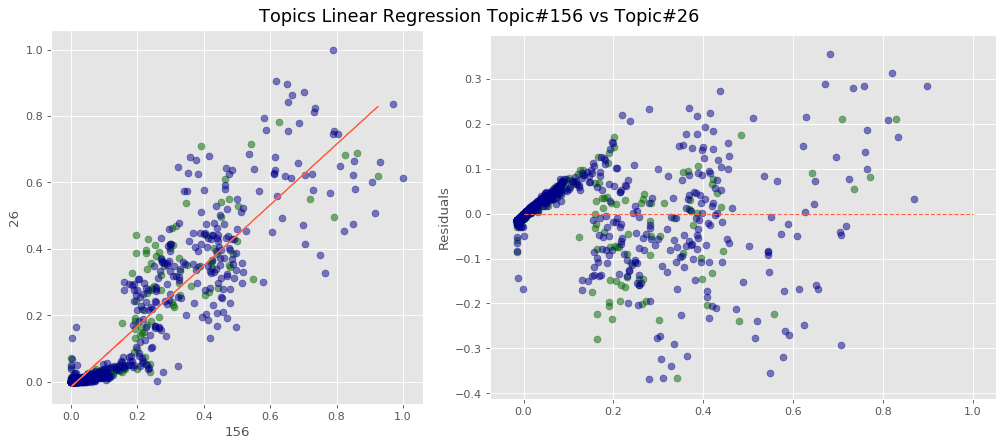

In [25]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5.5), dpi=dpi)

axes[0].scatter(xTest, yTest,  color='darkgreen', s=40, alpha=0.5)
axes[0].scatter(xTrain, yTrain,  color='darkblue', s=40, alpha=0.5)
axes[0].plot(xTest, yPred, color='tomato', linewidth=1)
axes[0].set_xlabel(pair[0])
axes[0].set_ylabel(pair[1])
axes[0].set_aspect('equal', 'box')

axes[1].scatter(yPred, yPred - yTest, color='darkgreen', s=40, alpha=0.5)
axes[1].scatter(lr.predict(xTrain), lr.predict(xTrain) - yTrain,  color='darkblue', s=40, alpha=0.5)
axes[1].hlines(y=0, xmin=0, xmax=1, color='tomato', linewidth=1, linestyle='--')
axes[1].set_ylabel('Residuals')
axes[1].set_aspect('equal', 'box')

fig.suptitle('Topics Linear Regression Topic#{} vs Topic#{}'.format(pair[0], pair[1]), fontsize=16)
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.subplots_adjust(top=0.93, wspace=0)
plt.show()

**Here we used a simple linear regression to find correlation between topics, the result is not as good as expected, for example, we see from "Average Weight Topic Over Time" plot there is positive correlation between topic 44 and topic 100, and negative correlation between topic 24 and topic 44, during a specific range of year, but we can not detect it using simple linear regression. There are many other more effective methods to anaylize correlation, such as time series Pearson correlation, we take it as future work by now.**

**The range of time may affect the regression a lot, in specific period time the correlation between topics may appear stronger than the whole time range.**

**By applying regression on topics, we can evaluate the relationship between topics quantitively, and have more change to find (or even predict) interesting patterns or features in topics.**

---

In [26]:
sc.stop()
gc.collect()

59652